In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.graphics.tsaplots import acf as acf_func

plt.style.use("ggplot")
import arch
import yfinance as yf
import datetime as dt
import pmdarima as pm
from pmdarima import model_selection
from statsmodels.tsa.arima.model import ARIMA

We need to model volatility for risk management and trading.

# <font face="gotham" color="purple"> ARCH and GARCH</font>

**Conditional Heteroskedasticity** is the academic term for volatility clustering. $\text{ARCH}(1)$ formulation is

$$
\epsilon_t= \sigma_t w_t
$$
where $\{w_t\}$ is a white noise process.

$$
\sigma_t^2=\alpha_0 + \alpha_1 \epsilon_{t-1}^2
$$
$\{\epsilon_t\}$ is _autoregressive conditional heteroskedastic_ process with order unity.

A slight modification will show that how $\text{ARCH}$ models volatility
\begin{aligned}
\operatorname{Var}\left(\epsilon_t\right) & =\mathrm{E}\left[\epsilon_t^2\right]-\left(\mathrm{E}\left[\epsilon_t\right]\right)^2 \\
& =\mathrm{E}\left[\epsilon_t^2\right] \\
& =\mathrm{E}\left[w_t^2\right] \mathrm{E}\left[\alpha_0+\alpha_1 \epsilon_{t-1}^2\right] \\
& =\mathrm{E}\left[\alpha_0+\alpha_1 \epsilon_{t-1}^2\right] \\
& =\alpha_0+\alpha_1 \operatorname{Var}\left(\epsilon_{t-1}\right)
\end{aligned}
Simply put
$$
\operatorname{Var}=\alpha_0+\alpha_1 \operatorname{Var}\left(\epsilon_{t-1}\right)
$$
which is also an $\text{AR}(1)$.

For $\text{AR}(p)$
$$
\epsilon_t=w_t \sqrt{\alpha_0+\sum_{i=1}^p \alpha_p \epsilon_{t-i}^2}
$$

The counterpart of $\text{ARMA}$ is **Generalised Autoregressive Conditional Heteroskedastic** ($\text{GARCH}$), usually formulated as
$$
\begin{align}
\epsilon_t&= \sigma_t w_t\\
\sigma_t^2&=\alpha_0+\sum_{i=1}^q \alpha_i \epsilon_{t-i}^2+\sum_{j=1}^p \beta_j \sigma_{t-j}^2
\end{align}
$$
We say $\{\epsilon_t\}$ is a $\text{GARCH}(p, q)$ process.

# <font face="gotham" color="purple"> GARCH(1, 1) Simulation</font>

\begin{aligned}
\epsilon_t & =\sigma_t w_t \\
\sigma_t^2 & =\alpha_0+\alpha_1 \epsilon_{t-1}^2+\beta_1 \sigma_{t-1}^2
\end{aligned}
If $\alpha_1+\beta_1<1$, the system is stable, otherwise unstable.

Generate $\text{GARCH}(1, 1)$ data.

In [2]:
def gen_garch11(a0, a1, b1, N):
    w = np.random.randn(N)
    epsilon = np.zeros(N)
    sigma_sq = np.zeros(N)

    for i in range(1, N):
        sigma_sq[i] = a0 + a1 * epsilon[i - 1] ** 2 + b1 * sigma_sq[i - 1]
        epsilon[i] = w[i] * np.sqrt(sigma_sq[i])
    return epsilon

In [3]:
epsilon = gen_garch11(a0=0.2, a1=0.3, b1=0.4, N=1000)

Plot generated data and ACFs.

In [4]:
epsilon_acf = acf_func(epsilon, nlags=50)
epsilon_acf_sq = acf_func(epsilon**2, nlags=50)

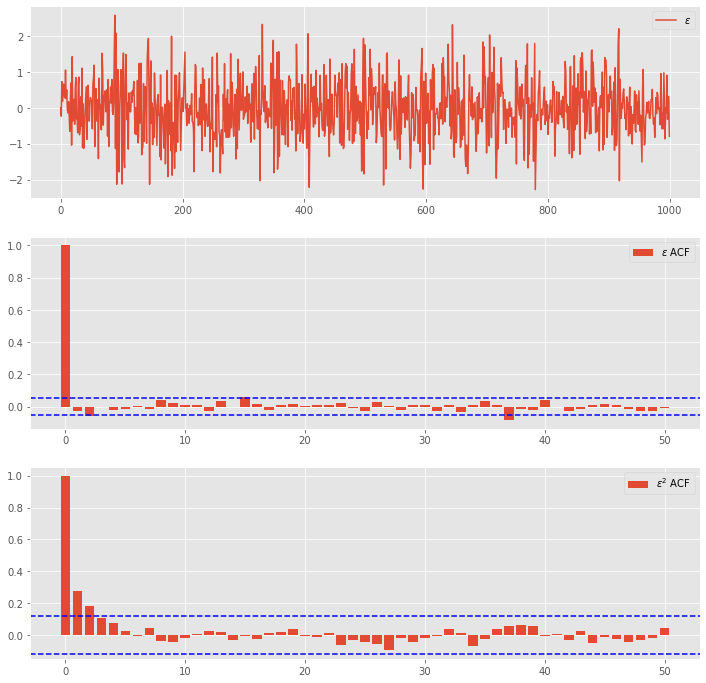

In [5]:
fig, ax = plt.subplots(figsize=(12, 12), nrows=3, ncols=1)
ax[0].plot(epsilon, label="$\epsilon$")

ax[1].bar(np.arange(len(epsilon_acf)), epsilon_acf, label="$\epsilon$ ACF")
ax[1].axhline(np.std(epsilon_acf[1:]) * 1.96, ls="--", color="b")
ax[1].axhline(-np.std(epsilon_acf[1:]) * 1.96, ls="--", color="b")

ax[2].bar(np.arange(len(epsilon_acf)), epsilon_acf_sq, label="$\epsilon^2$ ACF")
ax[2].axhline(np.std(epsilon_acf_sq[1:]) * 1.96, ls="--", color="b")
ax[2].axhline(-np.std(epsilon_acf_sq[1:]) * 1.96, ls="--", color="b")
for i in range(3):
    ax[i].legend()
plt.show()

Note that $\epsilon$ looks like white noise, in contrast $\epsilon^2$ shows autocorrelation and volatility clustering.

In [6]:
model = arch.arch_model(epsilon, mean="Zero", vol="GARCH", p=1, o=0, q=1)
res = model.fit()

Iteration:      1,   Func. Count:      5,   Neg. LLF: 1258453.449730941
Iteration:      2,   Func. Count:     10,   Neg. LLF: 1214.213872534293
Iteration:      3,   Func. Count:     16,   Neg. LLF: 1166.0516311962174
Iteration:      4,   Func. Count:     21,   Neg. LLF: 1155.3957037840642
Iteration:      5,   Func. Count:     25,   Neg. LLF: 1155.4068123183206
Iteration:      6,   Func. Count:     30,   Neg. LLF: 1155.3938598517461
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1155.3938598517461
            Iterations: 6
            Function evaluations: 30
            Gradient evaluations: 6


In [7]:
print(res.summary())

                       Zero Mean - GARCH Model Results                        
Dep. Variable:                      y   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.001
Vol Model:                      GARCH   Log-Likelihood:               -1155.39
Distribution:                  Normal   AIC:                           2316.79
Method:            Maximum Likelihood   BIC:                           2331.51
                                        No. Observations:                 1000
Date:                Wed, Jan 04 2023   Df Residuals:                     1000
Time:                        10:38:16   Df Model:                            0
                             Volatility Model                             
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega          0.1916  4.773e-02      4.014  5.962e-05 [9.805e-0

Compare estimated coefficients with our preset true value.

In [8]:
res.params

omega       0.191586
alpha[1]    0.291808
beta[1]     0.419334
Name: params, dtype: float64

# <font face="gotham" color="purple"> Fitting Nasdaq Data</font>

In [9]:
nasdaq = yf.download(
    ["^IXIC"],
    start=dt.datetime.today() - dt.timedelta(days=1500),
    end=dt.datetime.today(),
    progress=True,
    actions="inline",
    interval="1d",
)

[*********************100%***********************]  1 of 1 completed


In [10]:
nasdaq["log_ret"] = np.log(nasdaq["Adj Close"]) - np.log(nasdaq["Adj Close"].shift())
nasdaq = nasdaq.dropna()
nasdaq_acf = acf_func(nasdaq["log_ret"], nlags=50)

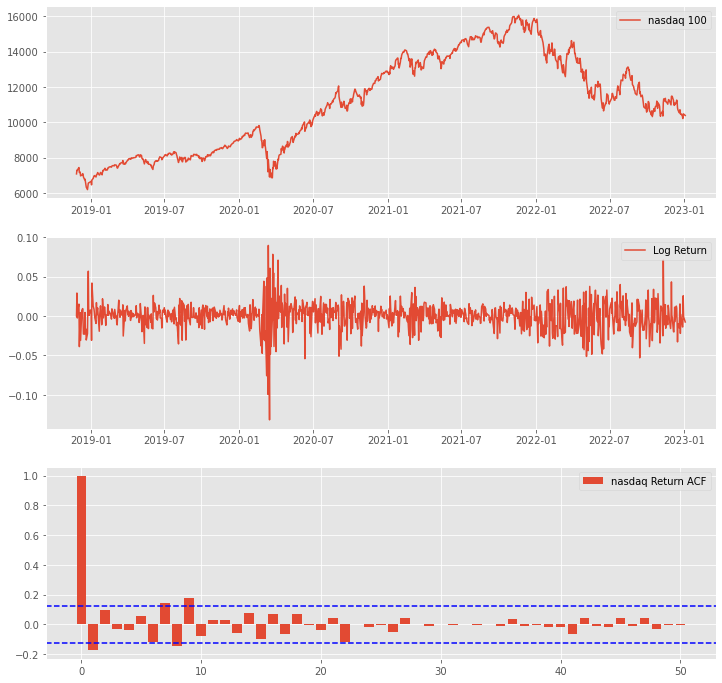

In [11]:
fig, ax = plt.subplots(figsize=(12, 12), nrows=3, ncols=1)
ax[0].plot(nasdaq["Adj Close"], label="nasdaq 100")
ax[1].plot(nasdaq["log_ret"], label="Log Return")

ax[2].bar(np.arange(len(nasdaq_acf)), nasdaq_acf, label="nasdaq Return ACF")
ax[2].axhline(np.std(nasdaq_acf[1:]) * 1.96, ls="--", color="b")
ax[2].axhline(-np.std(nasdaq_acf[1:]) * 1.96, ls="--", color="b")
for i in range(3):
    ax[i].legend()
plt.show()

Fit the model with $\text{ARIMA}$.

In [12]:
nasdaq.index = pd.DatetimeIndex(nasdaq.index).to_period(
    "D"
)  # without it, pandas will return warning

In [13]:
mod_obj = ARIMA(nasdaq["log_ret"], order=(2, 0, 2))
results = mod_obj.fit()

Now we want to see how much can't $\text{ARIMA}$ explain away in residual.

In [14]:
resid_acf = acf_func(results.resid, nlags=50)
resid_sq_acf = acf_func(results.resid**2, nlags=50)

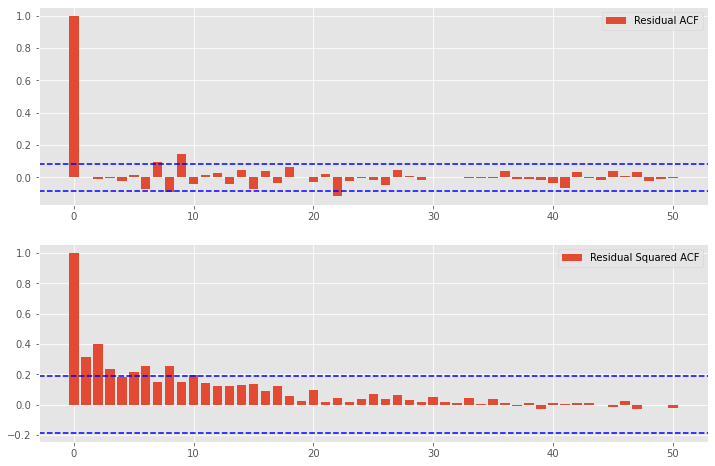

In [15]:
fig, ax = plt.subplots(figsize=(12, 8), nrows=2, ncols=1)
ax[0].bar(np.arange(len(resid_acf)), resid_acf, label="Residual ACF")
ax[0].axhline(np.std(resid_acf[1:]) * 1.96, ls="--", color="b")
ax[0].axhline(-np.std(resid_acf[1:]) * 1.96, ls="--", color="b")

ax[1].bar(np.arange(len(resid_sq_acf)), resid_sq_acf, label="Residual Squared ACF")
ax[1].axhline(np.std(resid_sq_acf[1:]) * 1.96, ls="--", color="b")
ax[1].axhline(-np.std(resid_sq_acf[1:]) * 1.96, ls="--", color="b")
for i in range(2):
    ax[i].legend()
plt.show()

Auto correlation presents in the squared residuals, we are able to confirm conditional heteroskedastic behavior is present in the diff log return series of the Nasdaq.

Therefore, we can fit a $\text{GARCH}$ model. Note, we are fitting the log return, not the residuals of $\text{ARIMA}$.

In [16]:
model_garch = arch.arch_model(
    nasdaq["log_ret"], mean="Zero", vol="GARCH", p=1, o=0, q=1
)
res = model.fit()

Iteration:      1,   Func. Count:      5,   Neg. LLF: 1258453.449730941
Iteration:      2,   Func. Count:     10,   Neg. LLF: 1214.213872534293
Iteration:      3,   Func. Count:     16,   Neg. LLF: 1166.0516311962174
Iteration:      4,   Func. Count:     21,   Neg. LLF: 1155.3957037840642
Iteration:      5,   Func. Count:     25,   Neg. LLF: 1155.4068123183206
Iteration:      6,   Func. Count:     30,   Neg. LLF: 1155.3938598517461
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1155.3938598517461
            Iterations: 6
            Function evaluations: 30
            Gradient evaluations: 6


In [17]:
resid_garch_sq = res.resid**2

In [18]:
resid_garch_sq_acf = acf_func(resid_garch_sq, nlags=50)

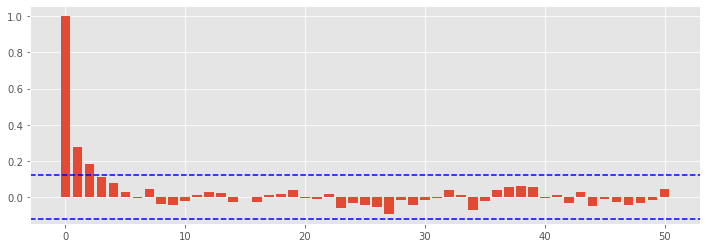

In [19]:
fig, ax = plt.subplots(figsize=(12, 4))
ax.bar(np.arange(len(resid_garch_sq_acf)), resid_garch_sq_acf)
ax.axhline(np.std(resid_garch_sq_acf[1:]) * 1.96, ls="--", color="b")
ax.axhline(-np.std(resid_garch_sq_acf[1:]) * 1.96, ls="--", color="b")
plt.show()

The residuals still shows autocorrelation, it could mean that model is misspecified, we will investigate further later.